<a href="https://colab.research.google.com/github/emsanqui/Task-to-Resource-Assignment-Optim/blob/main/Colab_Resource_Min_Task_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Min Resources for Fixed Task Assignments to Resources<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Task-Data" data-toc-modified-id="Task-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task Data</a></span></li><li><span><a href="#Finding-Feasible-Task-Combinations" data-toc-modified-id="Finding-Feasible-Task-Combinations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Finding Feasible Task Combinations</a></span><ul class="toc-item"><li><span><a href="#Find-All-Task-Pairs" data-toc-modified-id="Find-All-Task-Pairs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find All Task Pairs</a></span></li><li><span><a href="#Find-Only-the-Feasible-Task-Pairs" data-toc-modified-id="Find-Only-the-Feasible-Task-Pairs-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Find Only the Feasible Task Pairs</a></span></li><li><span><a href="#Feasible-Combinations" data-toc-modified-id="Feasible-Combinations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feasible Combinations</a></span></li><li><span><a href="#Cost-of-Feasible-Combinations" data-toc-modified-id="Cost-of-Feasible-Combinations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Cost of Feasible Combinations</a></span></li></ul></li><li><span><a href="#Optimize-Task-Assignments" data-toc-modified-id="Optimize-Task-Assignments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimize Task Assignments</a></span><ul class="toc-item"><li><span><a href="#Find-Minimum-Resources-Needed" data-toc-modified-id="Find-Minimum-Resources-Needed-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Find Minimum Resources Needed</a></span><ul class="toc-item"><li><span><a href="#Minimum-Resources-Needed" data-toc-modified-id="Minimum-Resources-Needed-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Minimum Resources Needed</a></span></li></ul></li><li><span><a href="#Minimum-Hours-given-Minimum-Resource-Count" data-toc-modified-id="Minimum-Hours-given-Minimum-Resource-Count-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Minimum Hours given Minimum Resource Count</a></span><ul class="toc-item"><li><span><a href="#Set-Number-of-Resources" data-toc-modified-id="Set-Number-of-Resources-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Set Number of Resources</a></span></li><li><span><a href="#Minimum-Hours" data-toc-modified-id="Minimum-Hours-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Minimum Hours</a></span></li></ul></li><li><span><a href="#Summarize-Recommended-Assignments" data-toc-modified-id="Summarize-Recommended-Assignments-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Summarize Recommended Assignments</a></span></li></ul></li></ul></div>

In [ ]:
#@title
!pip -qq install 'pyomo[optional]'
!apt-get install -y -qq coinor-cbc
!pip install -qq --upgrade plotly

     |████████████████████████████████| 9.6 MB 12.9 MB/s 
     |████████████████████████████████| 49 kB 3.0 MB/s 
     |████████████████████████████████| 54.5 MB 110 kB/s 
     |████████████████████████████████| 34.2 MB 34 kB/s 
     |████████████████████████████████| 99 kB 5.5 MB/s 
     |████████████████████████████████| 209 kB 60.5 MB/s 
     |████████████████████████████████| 189 kB 63.6 MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking c

In [ ]:
#@title
import pandas as pd
import numpy as np
import networkx as nx 
from IPython.display import Markdown

# import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

import matplotlib.pyplot as plt

import pyomo
from pyomo.core.expr.numeric_expr import LinearExpression
import pyomo.environ as pyo

# from tqdm.notebook import tqdm

In [ ]:
#@title
class assignmentCombination(object):
    def __init__(self, inTaskList):
        self.tasks_df = task_df[task_df.TASK.isin(inTaskList)]
        self.min_shift_duration = pd.Timedelta(hours=3, minutes=30)
        self.calcDuration()
        
    def calcDuration(self):
        if self.tasks_df.END.max() - self.tasks_df.START.min() < self.min_shift_duration:
            self.duration = self.min_shift_duration
        else:
            self.duration = self.tasks_df.END.max() - self.tasks_df.START.min()
            
    def display(self):
        display(Markdown(f"#### Total Duration {self.duration}"))
        display( self.tasks_df )
        
    def makeGantt(self, resource_number=0):
        fig = px.timeline(self.tasks_df, x_start="START", x_end="END", y="TASK", 
                          height=len(self.tasks_df)*49+140, text="TASK",
                          labels={'TASK':f'Resource {resource_number+1}<br>Task Assignment'})
        fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
        
        fig.update_xaxes(
            rangeslider_visible=True,
            rangeselector=dict(
                buttons=list([
                    dict(step="all")
                ])
            )
        )
        
        fig.show(renderer="colab")
        del fig

## Introduction

There are instances where we have a set of fixed tasks (items), which need to be assigned to resources, such that the total number of hours (cost) are minimized.  Examples of these problems include:

* Load and Unload AC assignments to Crews, 
* GSE assignments to flights,
* Route assignments to drivers

In these examples, the goal is to assign a set of given tasks with fixed start and end times to a number of resources, while minimizing total resources and hours.

Under this approach our assumptions include:

* Task Start and End times are fixed
* There are a minimum and maximum number of hours a resource can work
* There is an overtime cost for assignments over 8 hours
* The gap between the end of one task and the start of the next task have a minimum and maximum allowed

## Task Data



In [ ]:
#@title
task_df = pd.read_csv('https://raw.githubusercontent.com/emsanqui/Task-to-Resource-Assignment-Optim/main/TASKS.csv', parse_dates=['START','END'])
task_df

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
1,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00
2,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00
3,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00
5,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00


In [ ]:
#@title
fig = px.timeline(task_df, x_start="START", x_end="END", y="TASK", height=len(task_df)*77)

fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(step="all")
        ])
    )
)

fig.show(renderer="colab")

## Finding Feasible Task Combinations

### Find All Task Pairs
We can find all task pairs and calculate the duration of the gap between the end of the first task and the start of the following task.  These durations can be either positive or negative.  In this example these duration are in the **T1_T2_GAP** column.

In [ ]:
#@title
dat = task_df.copy()
dat['j']=1
combi_df = pd.merge(left=dat, right=dat, how='left', on='j', suffixes=('', '_2')).drop('j',axis=1)
combi_df['T1_T2_GAP'] = combi_df.START_2 - combi_df.END
combi_df.query("TASK!=TASK_2", inplace=True)
display(Markdown(f"**Total of {len(combi_df)} pairings, including feasible and infeasible task pairs**"))
combi_df.reset_index(inplace=True, drop=True)
combi_df

**Total of 30 pairings, including feasible and infeasible task pairs**

,TASK,START,END,TASK_2,START_2,END_2,T1_T2_GAP
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,0 days 00:10:00
1,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00,0 days 00:15:00
2,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00,0 days 00:20:00
3,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00,0 days 00:35:00
4,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00,0 days 02:45:00
5,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,-1 days +23:15:00
6,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00,-1 days +23:45:00
7,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00,-1 days +23:50:00
8,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00,0 days 00:05:00
9,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00,0 days 02:15:00


### Find Only the Feasible Task Pairs
Having these durations allows us to define rules to define what is considered a feasible task pair and what is infeasible task pair.  In this simple example we only use two rules:
* The **T1_T2_GAP** needs to be at least a minimum number of minutes
* The **T1_T2_GAP** needs to be at most a maximum number of minutes

In [ ]:
#@title
# display(Markdown(f'We give minimum and maximum times between tasks.'))

MIN_BREAK_TIME = input("  Minimum Minutes between Tasks [5 minutes]: ")
try:
    MIN_BREAK_TIME = int(MIN_BREAK_TIME)
except:
    MIN_BREAK_TIME = 5
    
MIN_BREAK_TIME = pd.Timedelta(minutes=MIN_BREAK_TIME)


MAX_BREAK_TIME = input("  Maximum Minutes between Tasks [120 minutes]: ")
try:
    MAX_BREAK_TIME = int(MAX_BREAK_TIME)
except:
    MAX_BREAK_TIME = 120
    
MAX_BREAK_TIME = td = pd.Timedelta(minutes=MAX_BREAK_TIME)


display(Markdown(f'''Here we will use a minimum of {MIN_BREAK_TIME} between tasks 
and a maximum of {MAX_BREAK_TIME} between tasks.'''))

feas_combi_df = combi_df[(combi_df['T1_T2_GAP']>=MIN_BREAK_TIME) &
                         (combi_df['T1_T2_GAP']<=MAX_BREAK_TIME)]

display(Markdown(f"**Total of {len(feas_combi_df)} feasible pairings**"))

feas_combi_df

  Minimum Minutes between Tasks [5 minutes]: 
  Maximum Minutes between Tasks [120 minutes]: 


Here we will use a minimum of 0 days 00:05:00 between tasks 
and a maximum of 0 days 02:00:00 between tasks.

**Total of 6 feasible pairings**

,TASK,START,END,TASK_2,START_2,END_2,T1_T2_GAP
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,0 days 00:10:00
1,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00,0 days 00:15:00
2,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00,0 days 00:20:00
3,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00,0 days 00:35:00
8,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00,0 days 00:05:00
24,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00,0 days 01:30:00


### Feasible Combinations
Having the feasible pairings we can build a set of feasible task combinations to evaluate. 

In [ ]:
#@title
display('; '.join([f"{f[0]}->{f[1]}: {f[2].seconds/60:.0f} min" for f in feas_combi_df[['TASK','TASK_2','T1_T2_GAP']].values]))

'TASK_A->TASK_B: 10 min; TASK_A->TASK_C: 15 min; TASK_A->TASK_D: 20 min; TASK_A->TASK_E: 35 min; TASK_B->TASK_E: 5 min; TASK_E->TASK_F: 90 min'

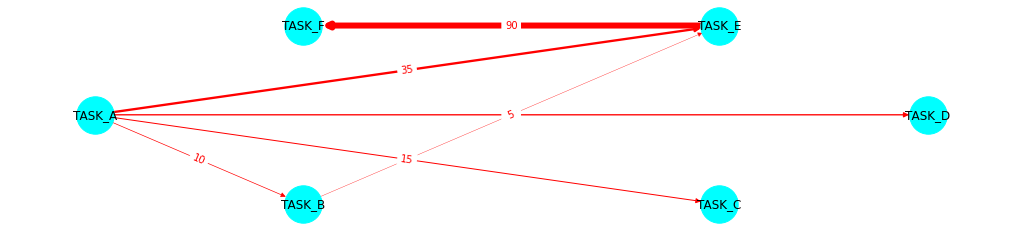

In [ ]:
#@title
G = nx.DiGraph()

nodes  = task_df.TASK
edges  = feas_combi_df[['TASK','TASK_2']].values.tolist()
gap_scale = 0.25
gap = [(g.seconds/3600/gap_scale) for g in feas_combi_df.T1_T2_GAP]
G.add_nodes_from(nodes)
G.add_edges_from(edges)

plt.figure(figsize=(14,3))
pos = nx.shell_layout(G)
nx.draw(G, with_labels=True, pos=pos, node_size=1400, width=gap, node_color='cyan', edge_color='red')

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(t[0],t[1]): t[2].seconds//60 
                 for t in feas_combi_df[['TASK','TASK_2','T1_T2_GAP']].values.tolist()},
    font_color='red'
);
# nx.draw_networkx_edges(G, pos, width=gap, edge_color=gap);
# plt.show()

In [ ]:
#@title
combinations = list(nx.enumerate_all_cliques(G.to_undirected()))
display(Markdown(f"In this example we have **{len(combinations)}** feasible combinations"))
combinations

In this example we have **13** feasible combinations

[['TASK_A'],
 ['TASK_B'],
 ['TASK_C'],
 ['TASK_D'],
 ['TASK_E'],
 ['TASK_F'],
 ['TASK_A', 'TASK_B'],
 ['TASK_A', 'TASK_C'],
 ['TASK_A', 'TASK_D'],
 ['TASK_A', 'TASK_E'],
 ['TASK_B', 'TASK_E'],
 ['TASK_E', 'TASK_F'],
 ['TASK_A', 'TASK_B', 'TASK_E']]

### Cost of Feasible Combinations
Each task combination can include different business rules for calculating the cost of each combination.
In this example we have the following two rules:
* The cost of a combination is at least 3.5 hours
* Time after 8 hours is 1.5 times straight hours 

In [ ]:
#@title
for i,c in enumerate(combinations):
    display(Markdown(f'''### Feasible Combination {i+1} includes {c}'''))
    assignmentCombination(c).display()

### Feasible Combination 1 includes ['TASK_A']

#### Total Duration 0 days 03:30:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00


### Feasible Combination 2 includes ['TASK_B']

#### Total Duration 0 days 03:30:00

,TASK,START,END
1,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00


### Feasible Combination 3 includes ['TASK_C']

#### Total Duration 0 days 11:20:00

,TASK,START,END
2,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00


### Feasible Combination 4 includes ['TASK_D']

#### Total Duration 0 days 03:30:00

,TASK,START,END
3,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00


### Feasible Combination 5 includes ['TASK_E']

#### Total Duration 0 days 03:30:00

,TASK,START,END
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00


### Feasible Combination 6 includes ['TASK_F']

#### Total Duration 0 days 03:30:00

,TASK,START,END
5,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00


### Feasible Combination 7 includes ['TASK_A', 'TASK_B']

#### Total Duration 0 days 03:30:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
1,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00


### Feasible Combination 8 includes ['TASK_A', 'TASK_C']

#### Total Duration 0 days 11:50:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
2,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00


### Feasible Combination 9 includes ['TASK_A', 'TASK_D']

#### Total Duration 0 days 03:30:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
3,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00


### Feasible Combination 10 includes ['TASK_A', 'TASK_E']

#### Total Duration 0 days 03:30:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00


### Feasible Combination 11 includes ['TASK_B', 'TASK_E']

#### Total Duration 0 days 03:30:00

,TASK,START,END
1,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00


### Feasible Combination 12 includes ['TASK_E', 'TASK_F']

#### Total Duration 0 days 04:10:00

,TASK,START,END
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00
5,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00


### Feasible Combination 13 includes ['TASK_A', 'TASK_B', 'TASK_E']

#### Total Duration 0 days 03:30:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
1,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00


## Optimize Task Assignments

In this example we use Integer Linear Programming

### Find Minimum Resources Needed

First we find the **_minimimum resource count_** required to support all tasks.

$$min{\sum_{b \in B} x_{b}}$$

$${\mkern35mu x_{b} \in \{0,1\}}{\mkern53mu \forall b \in B}$$

In [ ]:
#@title
display(Markdown(f"""
- **$t$** is a task in the set of tasks **$T$**.  We have **{len(task_df)} tasks** in this example.
- **$b$** is a feasible task combination in the set of feasible task assignment combinations **$B$**. We have **{len(combinations)} feasible combinations** in this example.
- **$x_{{b}}$** is the variable taking a value of *1* if the _**task combination**_ (**$b$**) is selected and *0* if excluded. In this example, the name of the variable are **Assignments[TASK_#]**.
"""))


- **$t$** is a task in the set of tasks **$T$**.  We have **6 tasks** in this example.
- **$b$** is a feasible task combination in the set of feasible task assignment combinations **$B$**. We have **13 feasible combinations** in this example.
- **$x_{b}$** is the variable taking a value of *1* if the _**task combination**_ (**$b$**) is selected and *0* if excluded. In this example, the name of the variable are **Assignments[TASK_#]**.


In [ ]:
#@title
model = pyo.ConcreteModel(name='Tasks Assignment')

model.Tasks = pyo.Set(initialize=task_df.TASK.values.astype(str),doc='Routes to assign')
# model.Tasks.pprint()

model.Combis = pyo.Set(initialize=[','.join(np.array(c).astype(str)) for c in combinations],
                       doc='Task combination to assign')
# model.Combis.pprint()

model.Assignments = pyo.Var(model.Combis, domain=pyo.Boolean, bounds=(0,1))

# delete objective functions if they exist
if hasattr(model, 'min_resources'):
    del(model.min_drivers)
elif hasattr(model, 'min_hours'):
    del(model.min_hours_lin_exp)
    
def min_resource_rule(model):
     return LinearExpression(constant=0,
                             linear_coefs=[1.0]*len(model.Assignments),
                             linear_vars=[model.Assignments[a] for a in model.Combis])
model.min_resources = pyo.Objective(rule=min_resource_rule, sense=pyo.minimize, doc='Minimize resource count')

OBJ1 = ' + '.join([a.to_string() for a in [model.Assignments[a] for a in model.Assignments]])
display(Markdown(f'''__*Minimize:*<br>{OBJ1}__'''))

__*Minimize:*<br>Assignments[TASK_A] + Assignments[TASK_B] + Assignments[TASK_C] + Assignments[TASK_D] + Assignments[TASK_E] + Assignments[TASK_F] + Assignments['TASK_A,TASK_B'] + Assignments['TASK_A,TASK_C'] + Assignments['TASK_A,TASK_D'] + Assignments['TASK_A,TASK_E'] + Assignments['TASK_B,TASK_E'] + Assignments['TASK_E,TASK_F'] + Assignments['TASK_A,TASK_B,TASK_E']__

We also need to ensure that each task is assigned only once.  We use __$m_{t,b}$__ taking a value of *1* if the task ($t$) is in the combination ($b$) and a values of *0* otherwise. 

$$s.t.{\sum_{b \in B}} {m_{t,b} x_{b} = 1}{\mkern53mu \forall t \in T}$$

In [ ]:
#@title
model.constrains_list = pyo.Constraint(pyo.Any)
rt_wo_combis_df = pd.DataFrame()
for r in model.Tasks:
    coefs = [1 if r in c else 0 for c in model.Combis]
    if np.sum(coefs)==0:
        rt_wo_combis_df = rt_wo_combis_df.append(Tasks.loc[np.int(r)])
    else:
        model.constrains_list[r] = LinearExpression(constant=0,
                                                    linear_coefs=coefs,
                                                    linear_vars=[model.Assignments[a] for a in model.Combis]
                                                    ) == 1.0


In [ ]:
#@title
display(Markdown(f"""
- **$t$** is a task in the set of tasks **$T$**, in this example **{len(task_df)} tasks**.
- **$b$** is a feasible task combination in the set of feasible task assignment combinations **$B$**, in this example **{len(combinations)} feasible combinations**.
- **$x_{{b}}$** is the variable taking a value of *1* if the _**task combination**_ (**$b$**) is selected and *0* if excluded.
"""))

i = len(task_df)-1

display(Markdown(f"""*e.g. Task '__{task_df.iloc[i].TASK}__' is in these assignment combinations* """))

SINGLE_ASSIGN_EXAMPLE = ' + '.join([a.to_string() 
                                    for a in [model.Assignments[a] 
                                              for a in model.Assignments 
                                              if task_df.iloc[i].TASK in a ]])

display(Markdown(f'__{SINGLE_ASSIGN_EXAMPLE} = 1__'))


- **$t$** is a task in the set of tasks **$T$**, in this example **6 tasks**.
- **$b$** is a feasible task combination in the set of feasible task assignment combinations **$B$**, in this example **13 feasible combinations**.
- **$x_{b}$** is the variable taking a value of *1* if the _**task combination**_ (**$b$**) is selected and *0* if excluded.


*e.g. Task '__TASK_F__' is in these assignment combinations* 

__Assignments[TASK_F] + Assignments['TASK_E,TASK_F'] = 1__

#### Minimum Resources Needed

In [ ]:
#@title
model.write(filename = 'min_resources.lp', io_options = {"symbolic_solver_labels":True})
solver = pyo.SolverFactory(_name='cbc',symbolic_solver_labels=True, executable='/usr/bin/cbc')
results = solver.solve(model)
# results.write()

pyoMINIMUM_RESOURCES = model.min_resources.expr()
display(Markdown(f'''## <span style='color:green'>In this example {pyoMINIMUM_RESOURCES:.0f} Resources are the minimum required to support the {len(task_df.TASK):,} scheduled tasks.</span>'''))

## <span style='color:green'>In this example 4 Resources are the minimum required to support the 6 scheduled tasks.</span>

### Minimum Hours given Minimum Resource Count

After finding the **_minimum resource count_**, we need to **_minimize hours_**, where **$c_{b}$** is the cost of each feasible task combination **$b$**.  In this example we use hours.

$$min{ \sum_{b \in B} c_{b} x_{b}}{}{}$$


In [ ]:
#@title
pyoASSIGNMENT_HOURS = pd.DataFrame(data=[[','.join(c), assignmentCombination(c).duration.seconds/3600] 
                                    for c in combinations], 
                              columns=['Assignment','Hours']).set_index('Assignment').to_dict()
# pyoASSIGNMENT_HOURS

In [ ]:
#@title
if hasattr(model, 'Hours'):
    del(model.Hours)
model.Hours = pyo.Param(model.Combis, initialize=pyoASSIGNMENT_HOURS['Hours'], default=0, within=pyo.NonNegativeReals)

####delete objective functions if they exist
if hasattr(model, 'min_resources'):
    del(model.min_resources)
elif hasattr(model, 'min_hours'):
    del(model.min_hours)
    
def min_hours_lin_rule(model):
    return LinearExpression(constant=0,
                            linear_coefs=[model.Hours[c] for c in model.Combis],
                            linear_vars=[model.Assignments[c] for c in model.Combis])
model.min_hours = pyo.Objective(rule=min_hours_lin_rule, sense=pyo.minimize, doc='Minimize total hours')

In [ ]:
#@title
OBJ2 = ' + '.join([f'{c:.2f}hrs x {v}' for c,v in 
                   zip(model.min_hours.expr.linear_coefs, model.min_hours.expr.linear_vars)])


display(Markdown('*In this example the objective is to minimize total hours cost, i.e.*'))
display(Markdown(f'__*Minimize:*<br>{OBJ2}__'))

*In this example the objective is to minimize total hours cost, i.e.*

__*Minimize:*<br>3.50hrs x Assignments[TASK_A] + 3.50hrs x Assignments[TASK_B] + 11.33hrs x Assignments[TASK_C] + 3.50hrs x Assignments[TASK_D] + 3.50hrs x Assignments[TASK_E] + 3.50hrs x Assignments[TASK_F] + 3.50hrs x Assignments['TASK_A,TASK_B'] + 11.83hrs x Assignments['TASK_A,TASK_C'] + 3.50hrs x Assignments['TASK_A,TASK_D'] + 3.50hrs x Assignments['TASK_A,TASK_E'] + 3.50hrs x Assignments['TASK_B,TASK_E'] + 4.17hrs x Assignments['TASK_E,TASK_F'] + 3.50hrs x Assignments['TASK_A,TASK_B,TASK_E']__

#### Set Number of Resources

We need to set the minimum resource count

$${\sum_{b \in B}} {x_{b} = {minimum{\mkern5mu}resource{\mkern5mu}count}}$$

In [ ]:
#@title
display(Markdown(f"*In this example we add the minimum number of resources we found earlier, i.e. __{pyoMINIMUM_RESOURCES:.0f}__*."))

pyoMAX_RESOURCES_CONSTRAINT = ' + '.join([a.to_string() for a in [model.Assignments[a] for a in model.Assignments]])

display(Markdown(f"**{pyoMAX_RESOURCES_CONSTRAINT} = {pyoMINIMUM_RESOURCES:.0f}**"))

*In this example we add the minimum number of resources we found earlier, i.e. __4__*.

**Assignments[TASK_A] + Assignments[TASK_B] + Assignments[TASK_C] + Assignments[TASK_D] + Assignments[TASK_E] + Assignments[TASK_F] + Assignments['TASK_A,TASK_B'] + Assignments['TASK_A,TASK_C'] + Assignments['TASK_A,TASK_D'] + Assignments['TASK_A,TASK_E'] + Assignments['TASK_B,TASK_E'] + Assignments['TASK_E,TASK_F'] + Assignments['TASK_A,TASK_B,TASK_E'] = 4**

In [ ]:
#@title
model.constrains_list['ResourcesUL'] = LinearExpression(constant=0,
                                                        linear_coefs=[1]*len(model.Combis),
                                                        linear_vars=[model.Assignments[a] for a in model.Combis]
                                                       ) == pyoMINIMUM_RESOURCES

#### Minimum Hours

In [ ]:
#@title
model.write(filename = 'min_hrs.lp', io_options = {"symbolic_solver_labels":True})
solver = pyo.SolverFactory(_name='cbc', executable='/usr/bin/cbc') 
# solver.options["sec"] = 60*10 # max run time in seconds
results = solver.solve(model, symbolic_solver_labels=True)
# results.write()

In [ ]:
#@title
pyoMINIMUM_HOURS = model.min_hours.expr()
display(Markdown(f'''## <span style='color:green'>In this example {pyoMINIMUM_HOURS:,.2f} Hours are the minimum required to support {len(model.Tasks):,} scheduled tasks.</span>'''))

## <span style='color:green'>In this example 21.83 Hours are the minimum required to support 6 scheduled tasks.</span>

### Summarize Recommended Assignments

We also get the selected task combinations and summarize them below.

In [ ]:
#@title
solution_df = (pd.DataFrame(data=[[i,model.Assignments.get_values()[i]] for i in model.Assignments.get_values()], 
                            columns=['Tasks','Values'])
               .query('Values==1'))
solution_df['Assignment'] = solution_df.Tasks.apply(lambda x: assignmentCombination(x.split(',')))

for i,ta in enumerate(solution_df.Assignment):
    display(Markdown('''<div style="background-color:black; height:5px; width:100%;"></div>'''))
    display(Markdown(f'## Resource {i+1}'))
    display(Markdown(f'**Total Cost in Hours: {ta.duration} hours**'))
    ta.display()
    ta.makeGantt(resource_number=i)  

<div style="background-color:black; height:5px; width:100%;"></div>

## Resource 1

**Total Cost in Hours: 0 days 11:20:00 hours**

#### Total Duration 0 days 11:20:00

,TASK,START,END
2,TASK_C,2022-05-21 01:30:00,2022-05-21 12:50:00


<div style="background-color:black; height:5px; width:100%;"></div>

## Resource 2

**Total Cost in Hours: 0 days 03:30:00 hours**

#### Total Duration 0 days 03:30:00

,TASK,START,END
3,TASK_D,2022-05-21 01:35:00,2022-05-21 01:50:00


<div style="background-color:black; height:5px; width:100%;"></div>

## Resource 3

**Total Cost in Hours: 0 days 03:30:00 hours**

#### Total Duration 0 days 03:30:00

,TASK,START,END
5,TASK_F,2022-05-21 04:00:00,2022-05-21 06:00:00


<div style="background-color:black; height:5px; width:100%;"></div>

## Resource 4

**Total Cost in Hours: 0 days 03:30:00 hours**

#### Total Duration 0 days 03:30:00

,TASK,START,END
0,TASK_A,2022-05-21 01:00:00,2022-05-21 01:15:00
1,TASK_B,2022-05-21 01:25:00,2022-05-21 01:45:00
4,TASK_E,2022-05-21 01:50:00,2022-05-21 02:30:00
